Image inpainting is the process of filling gaps, holes and defects in an image (for the sake of notation, they will be mentioned as hole in the rest of the article) so that filled-in pixel values change smoothly from the boundary toward the hole center. Due to the nature of the problem, differential equation is often used to solve for pixel values inside the hole with the boundary conditions are pixel values around the hole contour. 

In this article, I will go through steps of implementing an in-painting technique using biharmonic equation [1], which solves a $4^{th}$ order differential equation$. For the learning purpose, the main steps of the algorithm will be explained in detail. Hopefully, by doing it I could also fill in "gaps" in my knowledge. Another reason that I chose to implement this algorithm from scratch because the current implementation in Scikit-image, a popular image processing library in python, is quite not effective. As mentioned by the author in the Github page of the project [2], there still exists two problems regarding performance.

1. The first problem is about the size of the linear system. There are often multiple tiny holes in an image and we need to set up an independent linear system to solve for unknown pixels in each hole. The size of these linear systems just need to be equal to the number of unknown pixels inside each hole; however, the current implementation generates linear systems whose sizes are equal to the number pixel of the whole image. 

2. The second problem is regarding the formulation of the bi-laplacian matrix. Currently, bi-laplacian coefficients are calculated separately for each pixel while all of them, except ones next to the boundary, are the same.  

In the first part of the article, we will take a look at the image input and see how the holes look like. After that, I will describe how to isolate these holes from each other, so we can solve them independently. In the third part, detail steps of constructing the linear system for each hole will be presented. Finally we will set up the right-hand side of the linear system, solve it and enjoy the result.

The full code could be found on my Github [3]

# A quick glimpse on the input  

The input to our problem will be an image with a binary mask of the same size that defines where are the holes on the image. For the sake of testing, we will generate a number of random holes as in the below.

(<matplotlib.axes._subplots.AxesSubplot at 0x266239f30f0>,
 <matplotlib.image.AxesImage at 0x26623a5e978>)

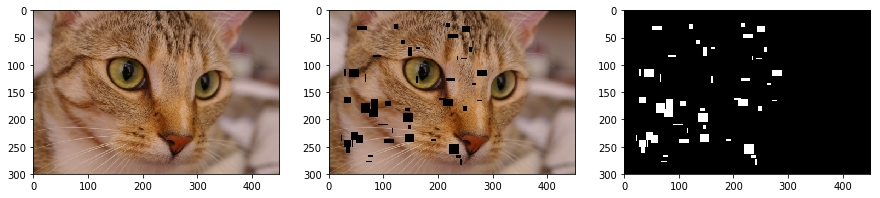

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import skimage.data as data
import numpy as np
img = data.chelsea()
img_hole = img.copy()
n_holes = 50
for i in range(n_holes):
    pos = np.random.randint(20, img.shape[0]-20, 2)
    hole_size = np.random.randint(1, 20, 2)
    img_hole[pos[0]:pos[0]+hole_size[0], pos[1]:pos[1]+hole_size[1]] = (0,0,0)
hole_mask = np.bitwise_and(np.bitwise_and(img_hole[:,:,0] == 0, img_hole[:,:,1] == 0), img_hole[:,:,2]==0)
plt.figure(figsize=(15,15))
plt.subplot(1,3,1), plt.imshow(img)
plt.subplot(1,3,2), plt.imshow(img_hole)
plt.subplot(1,3,3), plt.imshow(hole_mask, cmap='gray')

# Locate holes in the input image

We need to solve for unknown pixels by building up a linear system that constraints pixel values around the boundary of the hole and unknown pixels inside it. For doing that, first we need to isolate these holes to treat them independently. Because the biharmonic equation requires a band of two pixels around each hole as boundary condition, we have to dilate each hole with a structuring element of size 2. As displayed in below, all pixels inside each red contour will be the input to our next step: constructing the linear system of the biharmonic equation.

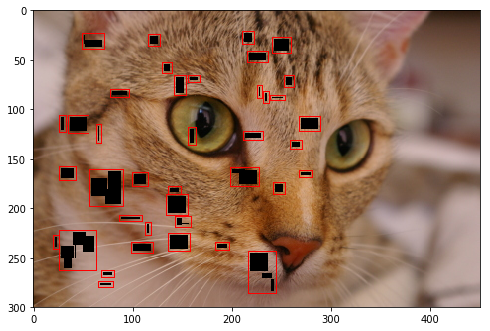

In [8]:
import scipy.ndimage as ndi
from skimage.measure import label, regionprops
def dilate_rect(rect, d, nd_shape):
    rect[0:2] = (rect[0:2] - d).clip(min = 0)
    rect[2:4] = (rect[2:4] + d).clip(max = nd_shape)
    return rect

def find_hole_components(image, mask):
    kernel = ndi.morphology.generate_binary_structure(mask.ndim, 1)
    mask_dilated = ndi.morphology.binary_dilation(mask, structure=kernel)
    mask_labeled, num_labels = label(mask_dilated, return_num=True)
    mask_labeled *= mask
    props = regionprops(mask_labeled)
    comp_out_imgs = []
    comp_masks = []
    debug_rects = []
    for i in range(num_labels):
        rect = np.array(props[i].bbox)
        rect = dilate_rect(rect, 2, image.shape[:2])
        debug_rects.append(rect)
        out_sub_img = image[rect[0]:rect[2], rect[1]:rect[3], :]
        comp_mask   = mask[rect[0]:rect[2], rect[1]:rect[3]]
        comp_out_imgs.append(out_sub_img)
        comp_masks.append(comp_mask)
        
    return comp_masks, comp_out_imgs, debug_rects

import skimage.draw as draw
comp_masks, comp_out_imgs, debug_rects = find_hole_components(img_hole, hole_mask)
debug_img = img_hole.copy()
for r in debug_rects:
    rr,cc = draw.polygon_perimeter([r[0], r[2], r[2], r[0]], [r[1], r[1], r[3], r[3]], debug_img.shape)
    debug_img[rr, cc] = (255,0,0)
plt.figure(figsize = (8,8))
plt.imshow(debug_img)
plt.show()

# Construct bi-laplacian matrix

Values of pixel inside the hole will be found by solving the biharmonic equation as below. In our case, we just count boundary conditions, so the function $f$ will be $0$. The $g$ function represents the boundary condition, which in our case depicts the values of pixel along hole contour.
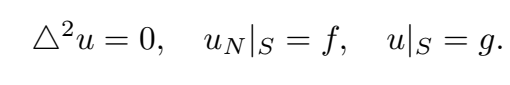

To discretize this bilaplacian equation, we use a  13-point finite difference scheme as following
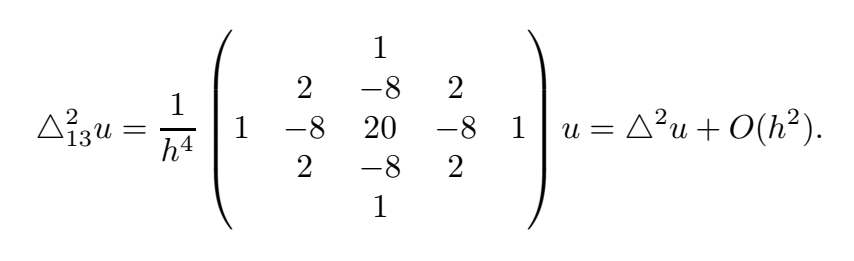

The stencil approximates a $4^{th}$ derivative at each pixel. Let take a pixel $u_{i,j}$ inside the hole as an example. Its coefficient will be $20$ and four coefficients $-8$ will be corresponding to pixels $\quad u_{i-1, j},\quad u_{i, j+1},\quad u_{i+1, j},\quad u_{i, j-1}$, and so on. From my understanding, these stencils describes the process of diffusion from pixel values on boundary toward the hole center.

Now, we need to build a linear system to solve for pixel values inside the hole. Each row of the linear system will correspond to a 13 stencil, describing the relations between an unknown pixel and its neighbors. Unfortunately, our 13-stencil is a 2D matrix, so one question is how we could represent this stencil on a row of our linear system? We do it by first numbering all unknown pixels from $0$ to $N$ and a row in our linear system will represent all of unknown pixels. The code below do this numbering step.

#### Number pixels inside hole

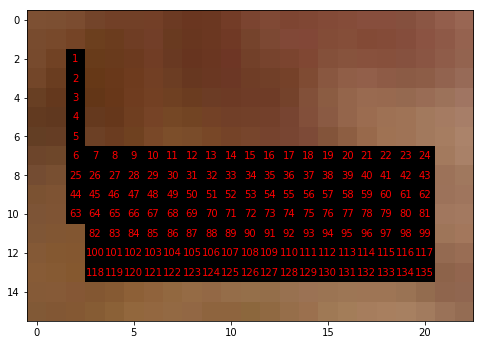

In [21]:
def numbergrid(mask):
    n = np.sum(mask)
    G1 = np.zeros_like(mask, dtype=np.uint32)
    G1[mask] = np.arange(1, n+1)
    return G1

hole_idx = np.random.randint(0, len(comp_masks))
rect = debug_rects[hole_idx]
mask = comp_masks[hole_idx]
rect_img =  img_hole[rect[0]:rect[2], rect[1]:rect[3]]
plt.rcParams["figure.figsize"] = (8,8)
ax = plt.gca()
ax.imshow(rect_img)
N = numbergrid(mask)
for i in range(N.shape[0]):
    for j in range(N.shape[1]):
        if N[i,j] != 0:
            ax.text(j,i, N[i,j], ha="center", va="center", color="r", fontsize=10)

#### Flatten out 13-centered bi-laplacian stencil

Now we will go deeper into the process of constructing our bi-laplacian matrix. As shown in below figure, the green unknown pixel has an index of 63, so the element $A_{63,63}$ will be set to $20$, which is the center coefficient in the 13-stencil. We then retrieve its neighbors and set their corresponding coefficients to the matrix.  

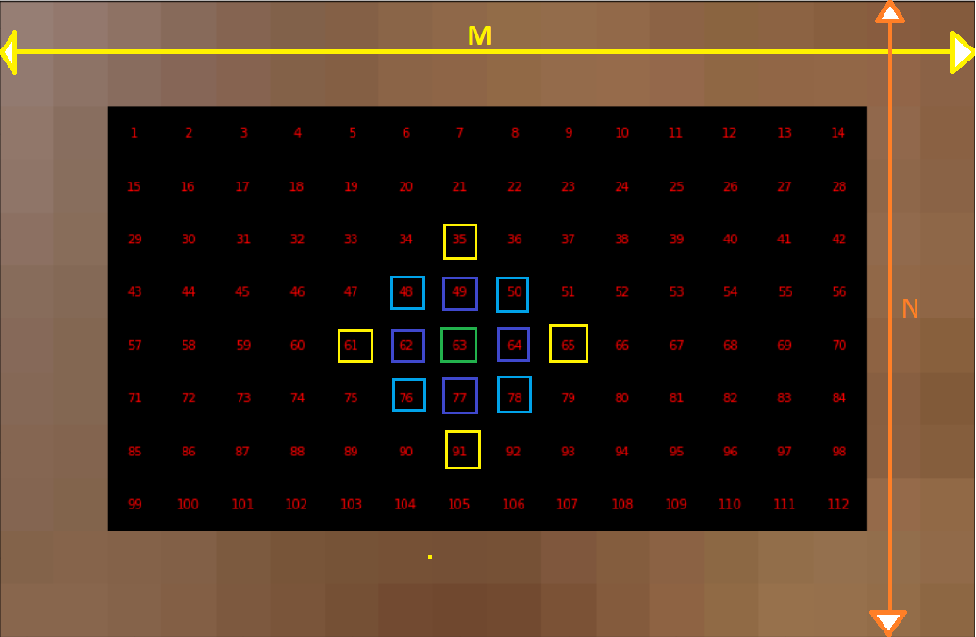

Based on the above idea, the below function generates the bi-laplacian matrix and visualize its structure

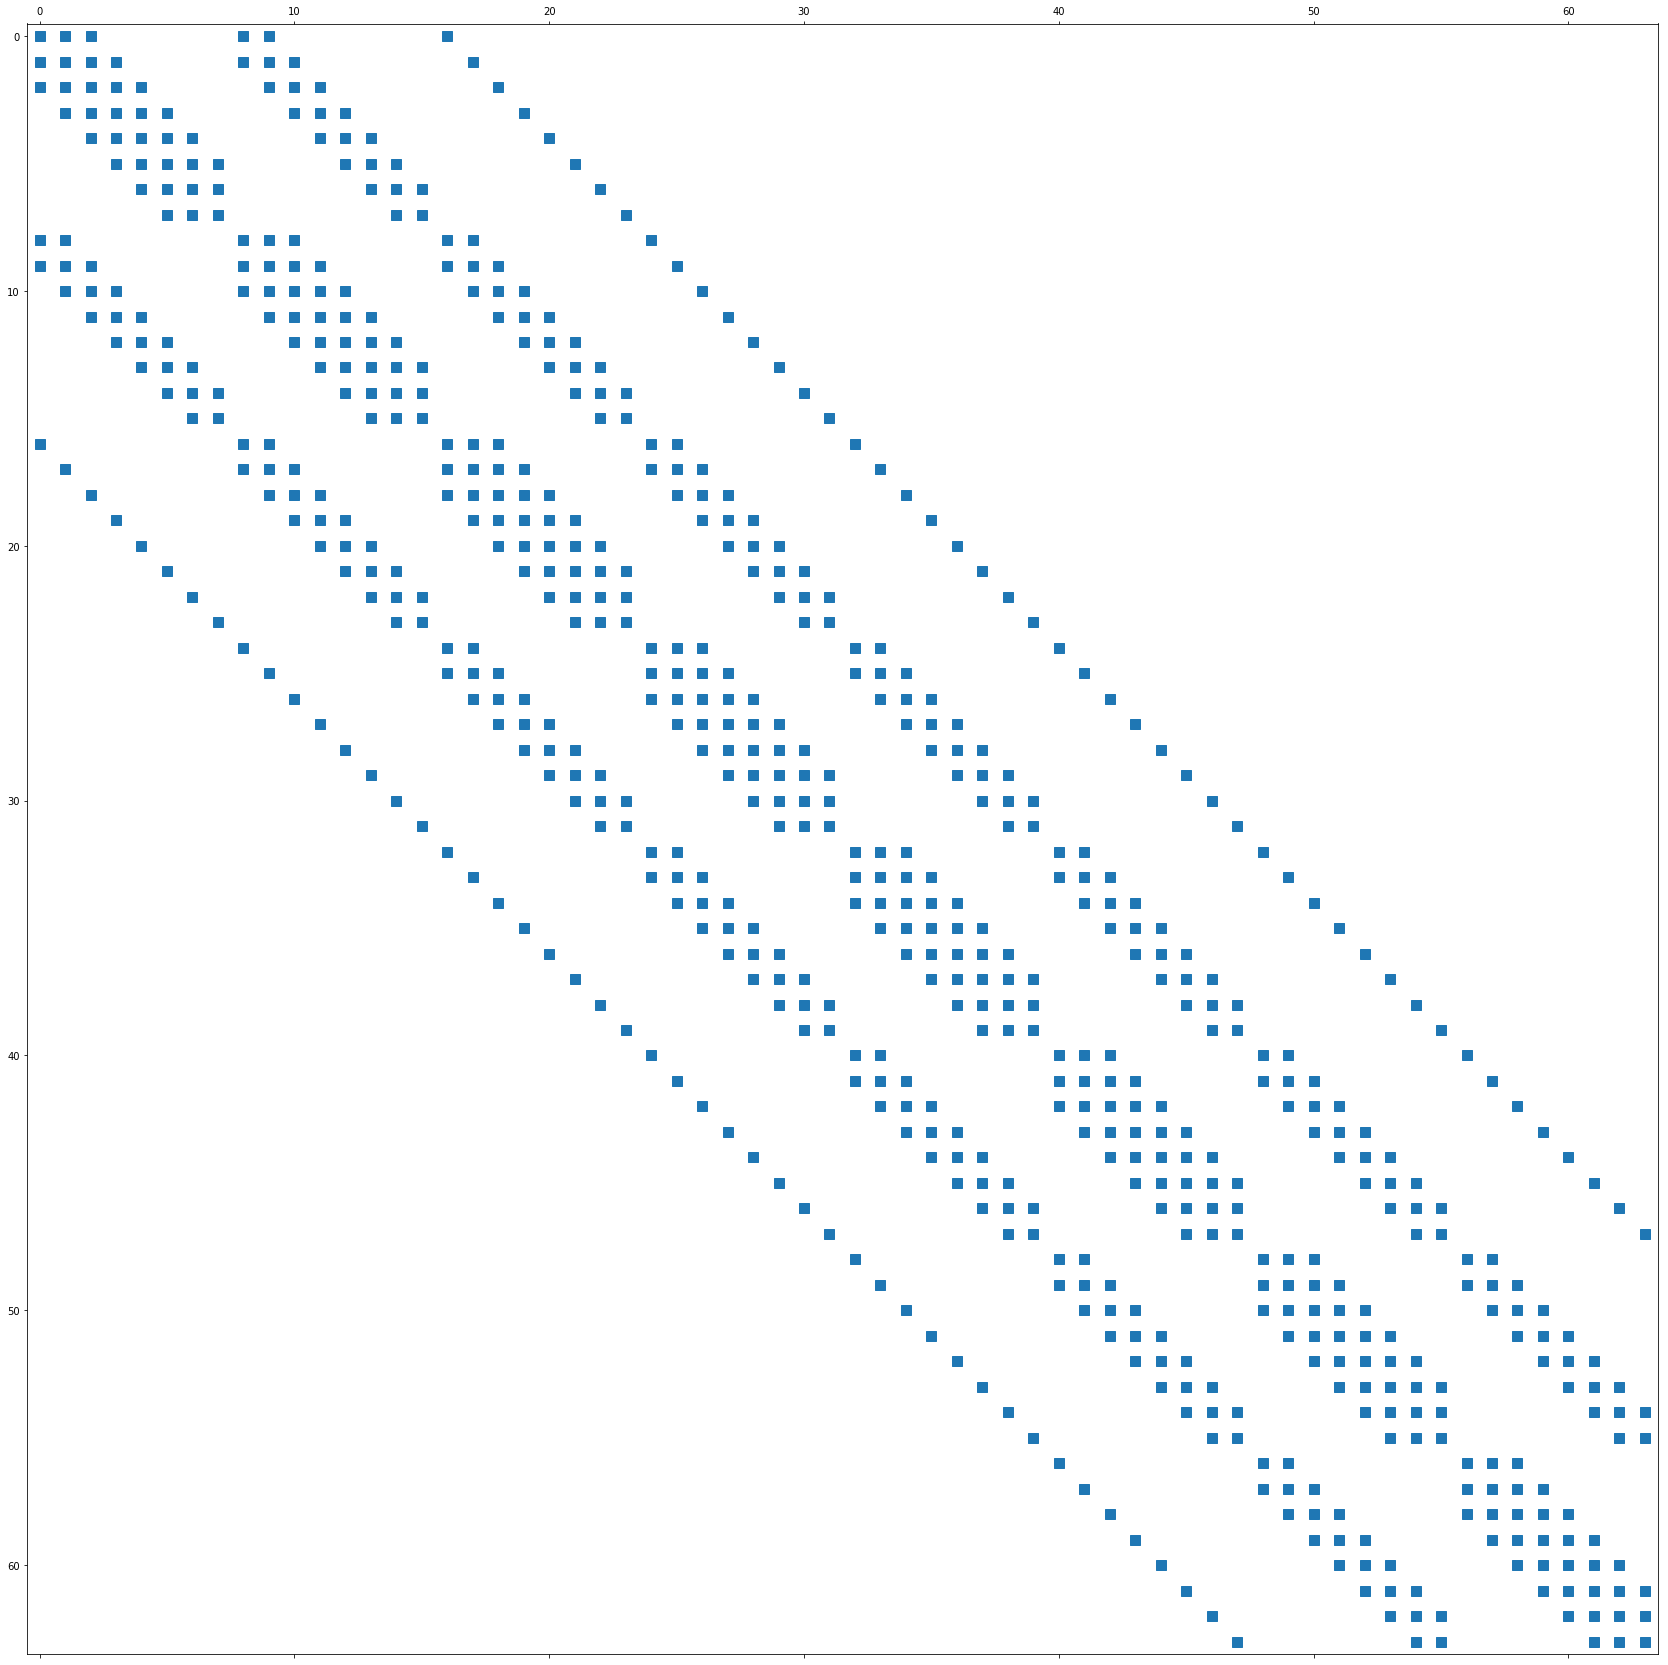

In [28]:
from scipy import sparse
def bi_laplacian(G):
    [n, m] = G.shape
    G1 = G.flatten()
    p = np.where(G1)[0]
    N = len(p)
    i = G1[p] - 1
    j = G1[p] - 1
    s = 20 * np.ones(N)
    #for all four neighbor of center points
    coeffs  = np.array([1, 2, -8, 2, 1, -8, -8, 1, 2, -8, 2, 1])
    offsets = np.array([-2*m, -m-1, -m, -m+1, -2, -1, 1, 2, m-1, m, m+1, 2*m])
    for coeff, offset in zip(coeffs, offsets):
        #indices of all possible neighbours in sparse matrix
        Q = G1[p+offset]
        #filter inner indices
        q = np.where(Q)[0]
        #generate neighbour coordinate
        i = np.concatenate([i, G1[p[q]]-1])
        j = np.concatenate([j, Q[q]-1])
        s = np.concatenate([s, coeff*np.ones(q.shape)])
    sp = sparse.csr_matrix((s, (i,j)), (N,N))
    return sp

hole_idx = np.random.randint(0, len(comp_masks))
mask = comp_masks[hole_idx]
G = numbergrid(mask)
L = bi_laplacian(G)
plt.spy(L)

# Solve the linear equation for unknown pixels

Finally, we come to the most interesting part: solving the linear system for unknown pixels. We split image into three channels and process them independently.

In [29]:
from scipy.sparse.linalg import spsolve
from scipy.ndimage.filters import laplace
from skimage import img_as_float
def fill_hole_single_channel(mask, out, limits):
    # Initialize sparse matrices
    matrix_unknown = sparse.lil_matrix((np.sum(mask), out.size))
    matrix_known = sparse.lil_matrix((np.sum(mask), out.size))

    # Find indexes of masked points in flatten array
    mask_i = np.ravel_multi_index(np.where(mask), mask.shape)

    G = numbergrid(mask)
    L = bi_laplacian(G)
    out[mask] = 0
    B = -laplace(laplace(out))
    b = B[mask]
    result = spsolve(L, b)
    # Handle enormous values
    result = np.clip(result, *limits)
    result = result.ravel()
    out[mask] = result
    #plt.imshow(out, cmap='gray')
    return out

def fill_hole(img_hole, mask):
    img_out = img_as_float(img_hole.copy())
    comp_masks, comp_out_imgs, _ = find_hole_components(img_out, mask)
    num_holes = len(comp_masks)
    for idx_channel in range(img_hole.shape[-1]):
        known_points = img_out[..., idx_channel][~mask]
        limits = (np.min(known_points), np.max(known_points))
        for i in range(num_holes):
            fill_hole_single_channel(comp_masks[i], comp_out_imgs[i][..., idx_channel], limits)
    return img_out

(<matplotlib.axes._subplots.AxesSubplot at 0x26623b43b38>,
 <matplotlib.image.AxesImage at 0x26623c48f28>)

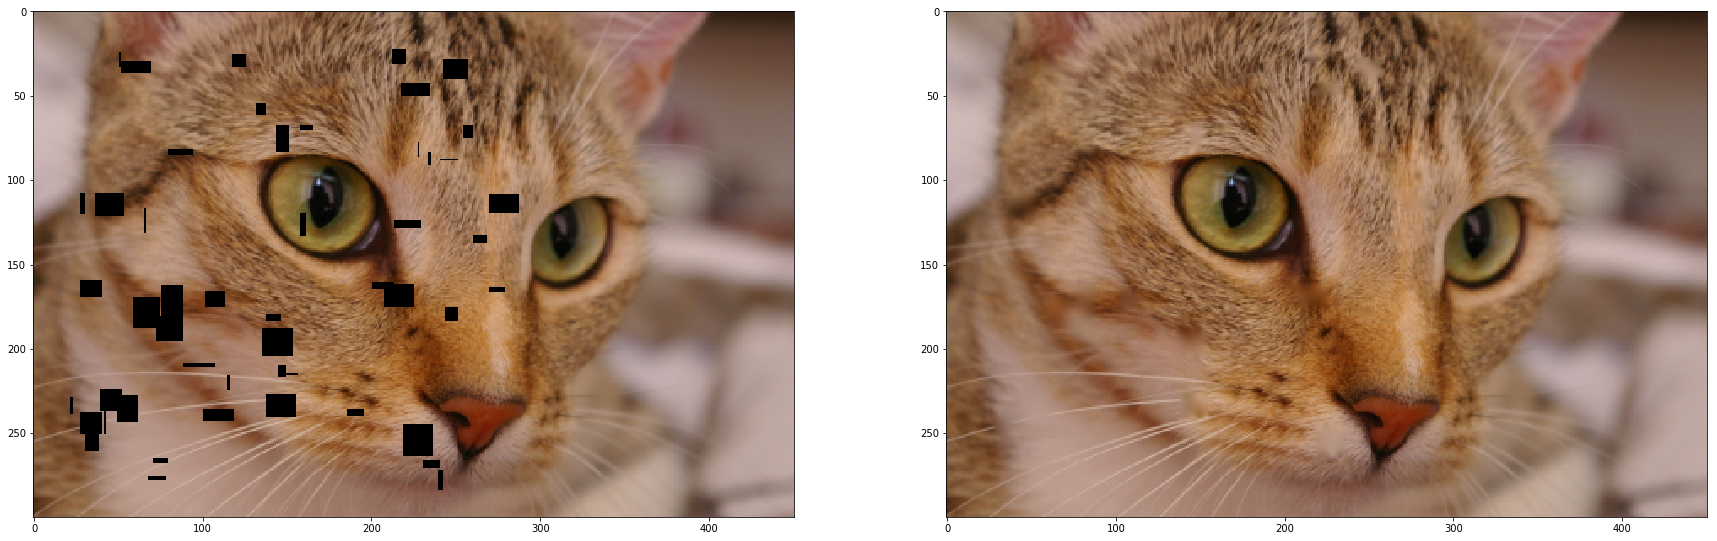

In [30]:
img_result = fill_hole(img_hole, hole_mask)
plt.rcParams['figure.figsize'] = (30,30)
plt.subplot(121), plt.imshow(img_hole)
plt.subplot(122), plt.imshow(img_result)

# Limitations

There is still a problem in this implementation regarding holes next to the image boundary. Biharmonic equation requires a band of two pixel around the hole boundary, but we don't have this boundary condition at holes along the image boundary. Therefore, we have to use special stencils for these boundary pixels, which is a bit more complicated because we have to treat these pixels independently. Currently, for boundary holes, our implementation will create black artifacts as in below.

(<matplotlib.axes._subplots.AxesSubplot at 0x26623d88780>,
 <matplotlib.image.AxesImage at 0x26623b91828>)

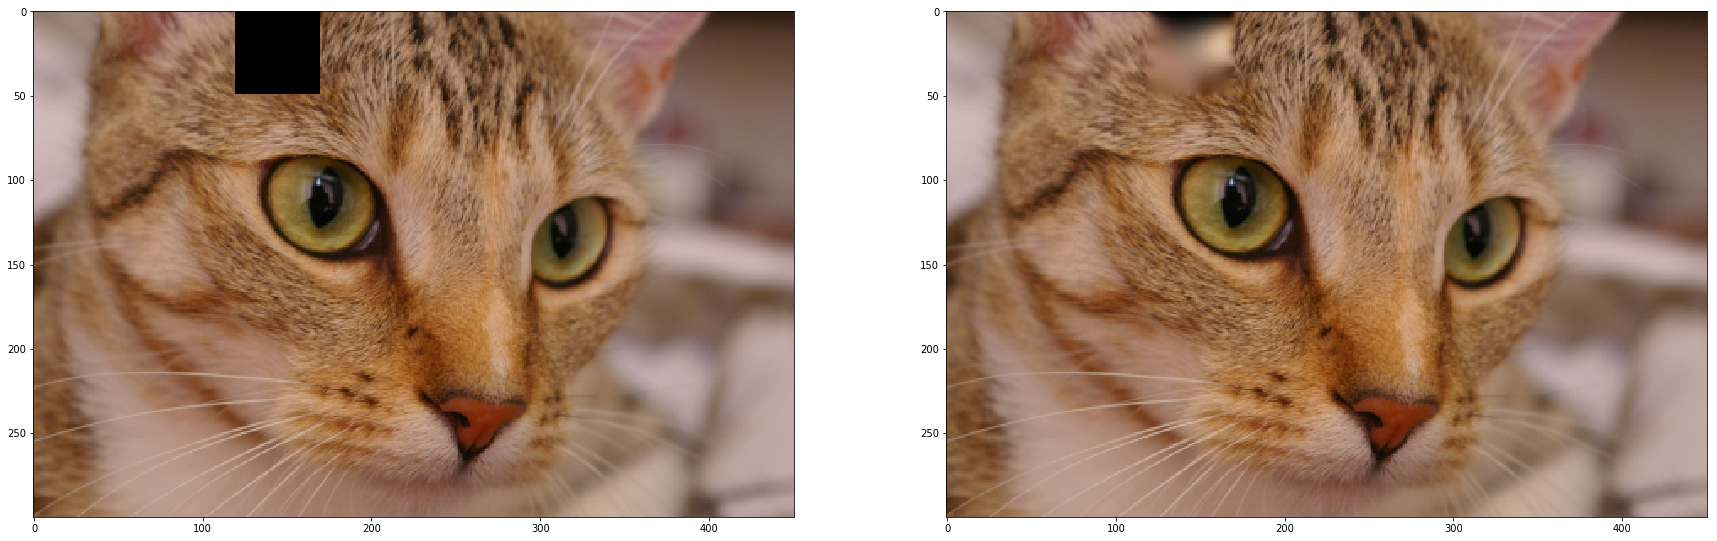

In [31]:
img_bdr_hole = img.copy()
img_bdr_hole[0:50, 120:170] = (0,0,0)
hole_bdr_mask = np.bitwise_and(np.bitwise_and(img_bdr_hole[:,:,0] == 0, img_bdr_hole[:,:,1] == 0), img_bdr_hole[:,:,2]==0)
img_black_artifacts = fill_hole(img_bdr_hole, hole_bdr_mask)
plt.rcParams['figure.figsize'] = (30,30)
plt.subplot(121), plt.imshow(img_bdr_hole)
plt.subplot(122), plt.imshow(img_black_artifacts)

# References

[1] Damelin, S. and Hoang, N. (2018). On Surface Completion and Image Inpainting by Biharmonic Functions: Numerical Aspects. International Journal of Mathematics and Mathematical Sciences, 2018, pp.1-8.

[2] https://github.com/scikit-image/scikit-image/issues/2008

[3] https://github.com/khanhha/image_inpainting